# Libraries

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib widget    # interactive 3d plots
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_evaluation
import plotting_utils
import model_training
from sklearn import linear_model
from sklearn import metrics
import copy
from mv_utils import lasso_rank, SVM_eval
# from tqdm import tqdm

/home/vrtx26/.local/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Feature (MFCC) extraction (Dataset generation)

In [3]:
# run this function if you need to generate a csv data set from scratch
X, y, ID = data_loader.load_dataset(should_generate_dataset=True, 
                                    use_vad=False, 
                                    use_delta_mfcc=False,
                                    use_delta_delta_mfcc=True)

{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}
INFO: n_fft=16384, n_mfcc=34
{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}


0it [00:00, ?it/s]

--- Data loaded. Loading time: 0.003998756408691406 seconds ---
X.shape =  (0, 0)
y.shape =  (0, 0)
ID.shape =  (0, 0)
data loaded in 0.010998964309692383ms
Empty DataFrame
Columns: []
Index: []
X.shape =  (0, 0)
X.columns =  Index([], dtype='object')


# Loading Dataset

In [2]:
X, y, ID = data_loader.load_dataset(X_path='data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv', 
                                    y_path='data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv',
                                    ID_path='data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv') 

data loaded in 0.09244561195373535ms
          0         1         2         3         4         5         6  \
0  0.327805 -0.464719 -0.540320 -0.983787 -1.276392 -0.517576 -0.059207   
1 -0.483202 -0.287426  0.073267 -0.259939 -1.043461  0.220426 -0.243781   
2 -0.982079  1.092156 -0.237941 -0.002997 -0.934974  0.313563  0.708375   
3  0.968642 -1.604765 -0.123183 -0.789169 -1.783557 -0.222486 -0.352760   
4  0.548607 -1.485735 -0.842989 -0.959707 -1.563772 -0.373401 -0.273213   

          7         8         9  ...       296       297       298       299  \
0 -1.325718 -0.865250 -1.400271  ... -0.000500  0.245232  0.467592  0.179897   
1 -0.745799 -0.558315 -0.667095  ...  0.081401 -0.156604  0.054227  1.335473   
2  0.392641 -0.112142 -0.675854  ...  1.159202 -0.281807  0.370446  0.969862   
3 -1.354752 -0.871037 -0.944073  ... -0.582348  1.606737 -1.213523  0.283672   
4 -1.374351 -0.530736 -0.333489  ... -0.312877 -1.016252 -0.713702  0.537837   

        300       301       302

## Relabeling and normilizing

In [3]:
y_true = np.zeros((len(y)))
y_true[np.squeeze(y.values=='disgust')] = 1
y_true[y_true==0] = -1

X_data = X.values
X_norm = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)
y_reg = copy.copy(y_true)

# LASSO ranking

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e+02, tolerance: 6.656e-02

Text(0, 0.5, 'Coeffs')

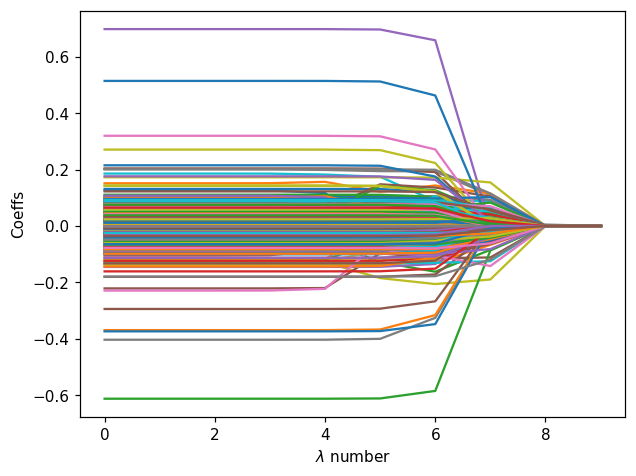

In [4]:
Lasso_model = linear_model.Lasso()
Npt = 10
coeffs = np.zeros((X_norm.shape[1],Npt))
lambda_ = np.logspace(-12.0, 0.5, Npt)
i = 0
for lamb in lambda_:
    Lasso_model = linear_model.Lasso(alpha=lamb, max_iter=20000)
    Lasso_model.fit(X_norm,y_reg)
    coeffs[:,i] = Lasso_model.coef_
    i = i + 1

plt.figure(dpi=110)
plt.plot(coeffs.T)
plt.xlabel('$\lambda$ number')
plt.ylabel('Coeffs')

In [5]:
Rank_lasso = []
for i in range(coeffs.shape[1]-1,-1,-1):
    withdraw_features = np.nonzero(coeffs[:,i])[0];
    something_new = np.setdiff1d(withdraw_features, Rank_lasso)
    if len(something_new):
        for ii in range(len(something_new)):
            Rank_lasso.append(something_new[ii])

In [6]:
np.save('data/Lasso_Ranking_disgust_result.npy', Rank_lasso)    # .npy extension is added if not given
Rank_lasso = np.load('data/Lasso_Ranking_disgust_result.npy')

# LOSO accuracy estimation

Iter =  1  AUC = 0.6290
Iter =  2  AUC = 0.6530
Iter =  3  AUC = 0.6560
Iter =  4  AUC = 0.6675
Iter =  7  AUC = 0.6897
Iter =  9  AUC = 0.6955
Iter =  10  AUC = 0.7029
Iter =  13  AUC = 0.7035
Iter =  18  AUC = 0.7214
Iter =  19  AUC = 0.7260
Iter =  25  AUC = 0.7358
Iter =  44  AUC = 0.7390
Iter =  45  AUC = 0.7420
Iter =  46  AUC = 0.7686
Iter =  47  AUC = 0.7716
Iter =  60  AUC = 0.7732
Iter =  70  AUC = 0.7750
Iter =  71  AUC = 0.7808
Iter =  73  AUC = 0.7973
Iter =  86  AUC = 0.7977
Iter =  91  AUC = 0.7997
Iter =  92  AUC = 0.8087
auc_best = 0.80869391


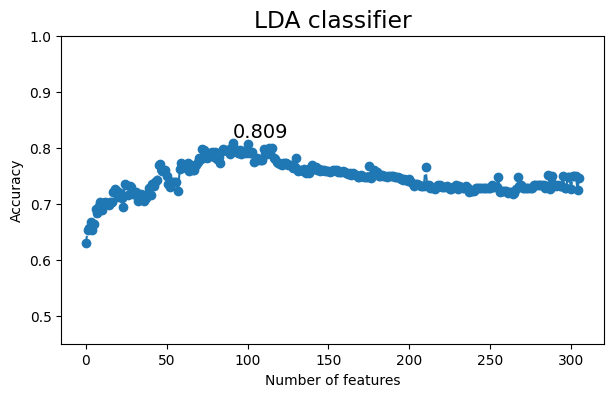

In [7]:
# Rank = lasso_rank(X,y)
# Rank = np.array(Rank)

# subj_IDs = np.squeeze(ID.values)

Rank = Rank_lasso
auc_svm = []
auc_best = 0
ind_best = 0
for k in range(1,len(Rank)+1):
    feature_inds = Rank[:k]
    auc = SVM_eval(X_norm,y_reg, feature_inds, ID)    
    auc_svm.append(auc)
    if (auc>auc_best):
        auc_best = auc
        ind_best = k-1
        print('Iter = ', k, f' AUC = {auc:.4f}' )
    
fig,ax=plt.subplots(figsize=(7,4),dpi=100)
plt.rcParams.update({'font.size': 14})
plt.plot(auc_svm,marker='o', linestyle='dashed')
plt.text(ind_best, auc_best+0.01, f'{auc_best:.3f}')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('LDA classifier')
plt.ylim([0.45, 1.00])

print(f'auc_best = {auc_best:.8f}')

# image_name = 'figures\\ACC_LDA_vowel_a.jpg'
# fig.savefig(image_name, bbox_inches='tight', pad_inches = 0.2)

In [8]:
print('best auc (LDA) = ', np.max(auc_svm), 'Number of features = ', np.argmax(auc_svm))

best auc (LDA) =  0.8086939102564102 Number of features =  91


# Backward step selection

In [9]:
def back_step_selection_loso(X,y,feature_ind, ID):
# BACK_STEP_SELECTION Automatic procedure of feature selection

#basic version
   acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
   some_feature_droped = True
   while (some_feature_droped):
      print('NEW ROUND')
      acc_up = -np.ones_like(feature_ind)
      for i in range(len(feature_ind)):
         cur_inds = np.setdiff1d(feature_ind,feature_ind[i])
         acc_mu = SVM_eval(X,y,cur_inds, ID)
         
         print(f'Iter #{i}: {acc_mu:.3f} <-> {acc_mu_curr:.3f}')
         
         if (acc_mu>=acc_mu_curr):
            acc_up[i] = acc_mu-acc_mu_curr
      m_val = np.max(acc_up)
      m_ind = np.argmax(acc_up)
      
      if (m_val>=0):
         print(f'Withdraw feature #{m_ind}, added accracy {m_val}')
         feature_ind = np.setdiff1d(feature_ind,feature_ind[m_ind]);
         some_feature_droped = True       
         # new basic version
         acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
      else:
         acc_final = acc_mu_curr
         some_feature_droped = False

   return acc_final, feature_ind

In [10]:
ind_best = np.argmax(auc_svm)
[acc_final,feature_ind] = back_step_selection_loso(X_norm, y_reg, Rank[:ind_best+1],ID)

NEW ROUND
Iter #0: 0.800 <-> 0.809
Iter #1: 0.806 <-> 0.809
Iter #2: 0.798 <-> 0.809
Iter #3: 0.792 <-> 0.809
Iter #4: 0.809 <-> 0.809
Iter #5: 0.777 <-> 0.809
Iter #6: 0.791 <-> 0.809
Iter #7: 0.796 <-> 0.809
Iter #8: 0.800 <-> 0.809
Iter #9: 0.798 <-> 0.809
Iter #10: 0.806 <-> 0.809
Iter #11: 0.808 <-> 0.809
Iter #12: 0.808 <-> 0.809
Iter #13: 0.809 <-> 0.809
Iter #14: 0.812 <-> 0.809
Iter #15: 0.811 <-> 0.809
Iter #16: 0.795 <-> 0.809
Iter #17: 0.793 <-> 0.809
Iter #18: 0.812 <-> 0.809
Iter #19: 0.805 <-> 0.809
Iter #20: 0.807 <-> 0.809
Iter #21: 0.808 <-> 0.809
Iter #22: 0.797 <-> 0.809
Iter #23: 0.811 <-> 0.809
Iter #24: 0.794 <-> 0.809
Iter #25: 0.802 <-> 0.809
Iter #26: 0.799 <-> 0.809
Iter #27: 0.813 <-> 0.809
Iter #28: 0.796 <-> 0.809
Iter #29: 0.799 <-> 0.809
Iter #30: 0.796 <-> 0.809
Iter #31: 0.812 <-> 0.809
Iter #32: 0.807 <-> 0.809
Iter #33: 0.803 <-> 0.809
Iter #34: 0.815 <-> 0.809
Iter #35: 0.815 <-> 0.809
Iter #36: 0.796 <-> 0.809
Iter #37: 0.791 <-> 0.809
Iter #38: 0.

Iter #38: 0.814 <-> 0.812
Iter #39: 0.806 <-> 0.812
Iter #40: 0.803 <-> 0.812
Iter #41: 0.812 <-> 0.812
Iter #42: 0.765 <-> 0.812
Iter #43: 0.816 <-> 0.812
Iter #44: 0.812 <-> 0.812
Iter #45: 0.805 <-> 0.812
Iter #46: 0.809 <-> 0.812
Iter #47: 0.813 <-> 0.812
Iter #48: 0.812 <-> 0.812
Iter #49: 0.812 <-> 0.812
Iter #50: 0.812 <-> 0.812
Iter #51: 0.812 <-> 0.812
Iter #52: 0.812 <-> 0.812
Iter #53: 0.811 <-> 0.812
Iter #54: 0.813 <-> 0.812
Iter #55: 0.807 <-> 0.812
Iter #56: 0.790 <-> 0.812
Iter #57: 0.808 <-> 0.812
Iter #58: 0.810 <-> 0.812
Iter #59: 0.806 <-> 0.812
Iter #60: 0.810 <-> 0.812
Iter #61: 0.794 <-> 0.812
Iter #62: 0.801 <-> 0.812
Iter #63: 0.808 <-> 0.812
Iter #64: 0.799 <-> 0.812
Iter #65: 0.809 <-> 0.812
Iter #66: 0.798 <-> 0.812
Iter #67: 0.810 <-> 0.812
Iter #68: 0.808 <-> 0.812
Iter #69: 0.811 <-> 0.812
Iter #70: 0.811 <-> 0.812
Iter #71: 0.813 <-> 0.812
Iter #72: 0.812 <-> 0.812
Iter #73: 0.812 <-> 0.812
Iter #74: 0.804 <-> 0.812
Iter #75: 0.812 <-> 0.812
Iter #76: 0.

Iter #85: 0.813 <-> 0.815
Withdraw feature #16, added accracy 0
NEW ROUND
Iter #0: 0.788 <-> 0.818
Iter #1: 0.789 <-> 0.818
Iter #2: 0.766 <-> 0.818
Iter #3: 0.774 <-> 0.818
Iter #4: 0.802 <-> 0.818
Iter #5: 0.804 <-> 0.818
Iter #6: 0.775 <-> 0.818
Iter #7: 0.797 <-> 0.818
Iter #8: 0.782 <-> 0.818
Iter #9: 0.805 <-> 0.818
Iter #10: 0.796 <-> 0.818
Iter #11: 0.796 <-> 0.818
Iter #12: 0.820 <-> 0.818
Iter #13: 0.819 <-> 0.818
Iter #14: 0.820 <-> 0.818
Iter #15: 0.816 <-> 0.818
Iter #16: 0.754 <-> 0.818
Iter #17: 0.782 <-> 0.818
Iter #18: 0.820 <-> 0.818
Iter #19: 0.813 <-> 0.818
Iter #20: 0.801 <-> 0.818
Iter #21: 0.807 <-> 0.818
Iter #22: 0.801 <-> 0.818
Iter #23: 0.782 <-> 0.818
Iter #24: 0.803 <-> 0.818
Iter #25: 0.780 <-> 0.818
Iter #26: 0.818 <-> 0.818
Iter #27: 0.821 <-> 0.818
Iter #28: 0.798 <-> 0.818
Iter #29: 0.801 <-> 0.818
Iter #30: 0.810 <-> 0.818
Iter #31: 0.751 <-> 0.818
Iter #32: 0.779 <-> 0.818
Iter #33: 0.821 <-> 0.818
Iter #34: 0.792 <-> 0.818
Iter #35: 0.815 <-> 0.818


Iter #57: 0.791 <-> 0.822
Iter #58: 0.808 <-> 0.822
Iter #59: 0.811 <-> 0.822
Iter #60: 0.803 <-> 0.822
Iter #61: 0.800 <-> 0.822
Iter #62: 0.817 <-> 0.822
Iter #63: 0.821 <-> 0.822
Iter #64: 0.817 <-> 0.822
Iter #65: 0.807 <-> 0.822
Iter #66: 0.810 <-> 0.822
Iter #67: 0.822 <-> 0.822
Iter #68: 0.820 <-> 0.822
Iter #69: 0.803 <-> 0.822
Iter #70: 0.819 <-> 0.822
Iter #71: 0.800 <-> 0.822
Iter #72: 0.823 <-> 0.822
Iter #73: 0.756 <-> 0.822
Iter #74: 0.813 <-> 0.822
Iter #75: 0.819 <-> 0.822
Iter #76: 0.821 <-> 0.822
Iter #77: 0.826 <-> 0.822
Iter #78: 0.822 <-> 0.822
Iter #79: 0.811 <-> 0.822
Iter #80: 0.823 <-> 0.822
Iter #81: 0.819 <-> 0.822
Withdraw feature #42, added accracy 0
NEW ROUND
Iter #0: 0.794 <-> 0.822
Iter #1: 0.804 <-> 0.822
Iter #2: 0.806 <-> 0.822
Iter #3: 0.753 <-> 0.822
Iter #4: 0.800 <-> 0.822
Iter #5: 0.813 <-> 0.822
Iter #6: 0.815 <-> 0.822
Iter #7: 0.815 <-> 0.822
Iter #8: 0.812 <-> 0.822
Iter #9: 0.819 <-> 0.822
Iter #10: 0.802 <-> 0.822
Iter #11: 0.803 <-> 0.822


Iter #45: 0.788 <-> 0.831
Iter #46: 0.829 <-> 0.831
Iter #47: 0.827 <-> 0.831
Iter #48: 0.811 <-> 0.831
Iter #49: 0.831 <-> 0.831
Iter #50: 0.811 <-> 0.831
Iter #51: 0.788 <-> 0.831
Iter #52: 0.832 <-> 0.831
Iter #53: 0.801 <-> 0.831
Iter #54: 0.785 <-> 0.831
Iter #55: 0.771 <-> 0.831
Iter #56: 0.817 <-> 0.831
Iter #57: 0.818 <-> 0.831
Iter #58: 0.828 <-> 0.831
Iter #59: 0.830 <-> 0.831
Iter #60: 0.820 <-> 0.831
Iter #61: 0.812 <-> 0.831
Iter #62: 0.822 <-> 0.831
Iter #63: 0.830 <-> 0.831
Iter #64: 0.832 <-> 0.831
Iter #65: 0.813 <-> 0.831
Iter #66: 0.830 <-> 0.831
Iter #67: 0.817 <-> 0.831
Iter #68: 0.808 <-> 0.831
Iter #69: 0.804 <-> 0.831
Iter #70: 0.807 <-> 0.831
Iter #71: 0.830 <-> 0.831
Iter #72: 0.822 <-> 0.831
Iter #73: 0.830 <-> 0.831
Iter #74: 0.830 <-> 0.831
Iter #75: 0.826 <-> 0.831
Iter #76: 0.831 <-> 0.831
Iter #77: 0.830 <-> 0.831
Withdraw feature #29, added accracy 0
NEW ROUND
Iter #0: 0.823 <-> 0.831
Iter #1: 0.815 <-> 0.831
Iter #2: 0.808 <-> 0.831
Iter #3: 0.825 <-> 

Iter #49: 0.799 <-> 0.843
Iter #50: 0.824 <-> 0.843
Iter #51: 0.818 <-> 0.843
Iter #52: 0.823 <-> 0.843
Iter #53: 0.832 <-> 0.843
Iter #54: 0.837 <-> 0.843
Iter #55: 0.835 <-> 0.843
Iter #56: 0.834 <-> 0.843
Iter #57: 0.814 <-> 0.843
Iter #58: 0.816 <-> 0.843
Iter #59: 0.821 <-> 0.843
Iter #60: 0.838 <-> 0.843
Iter #61: 0.789 <-> 0.843
Iter #62: 0.842 <-> 0.843
Iter #63: 0.822 <-> 0.843
Iter #64: 0.835 <-> 0.843
Iter #65: 0.834 <-> 0.843
Iter #66: 0.827 <-> 0.843
Iter #67: 0.840 <-> 0.843
Iter #68: 0.842 <-> 0.843
Iter #69: 0.834 <-> 0.843
Iter #70: 0.831 <-> 0.843
Iter #71: 0.840 <-> 0.843
Iter #72: 0.828 <-> 0.843
Iter #73: 0.819 <-> 0.843
Withdraw feature #22, added accracy 0
NEW ROUND
Iter #0: 0.800 <-> 0.845
Iter #1: 0.805 <-> 0.845
Iter #2: 0.811 <-> 0.845
Iter #3: 0.812 <-> 0.845
Iter #4: 0.829 <-> 0.845
Iter #5: 0.837 <-> 0.845
Iter #6: 0.814 <-> 0.845
Iter #7: 0.826 <-> 0.845
Iter #8: 0.821 <-> 0.845
Iter #9: 0.809 <-> 0.845
Iter #10: 0.820 <-> 0.845
Iter #11: 0.818 <-> 0.845


Iter #69: 0.844 <-> 0.850
Withdraw feature #33, added accracy 0
NEW ROUND
Iter #0: 0.801 <-> 0.850
Iter #1: 0.805 <-> 0.850
Iter #2: 0.806 <-> 0.850
Iter #3: 0.814 <-> 0.850
Iter #4: 0.831 <-> 0.850
Iter #5: 0.836 <-> 0.850
Iter #6: 0.813 <-> 0.850
Iter #7: 0.766 <-> 0.850
Iter #8: 0.840 <-> 0.850
Iter #9: 0.806 <-> 0.850
Iter #10: 0.821 <-> 0.850
Iter #11: 0.839 <-> 0.850
Iter #12: 0.824 <-> 0.850
Iter #13: 0.832 <-> 0.850
Iter #14: 0.842 <-> 0.850
Iter #15: 0.814 <-> 0.850
Iter #16: 0.849 <-> 0.850
Iter #17: 0.821 <-> 0.850
Iter #18: 0.834 <-> 0.850
Iter #19: 0.834 <-> 0.850
Iter #20: 0.816 <-> 0.850
Iter #21: 0.833 <-> 0.850
Iter #22: 0.769 <-> 0.850
Iter #23: 0.787 <-> 0.850
Iter #24: 0.795 <-> 0.850
Iter #25: 0.823 <-> 0.850
Iter #26: 0.831 <-> 0.850
Iter #27: 0.814 <-> 0.850
Iter #28: 0.834 <-> 0.850
Iter #29: 0.839 <-> 0.850
Iter #30: 0.816 <-> 0.850
Iter #31: 0.828 <-> 0.850
Iter #32: 0.849 <-> 0.850
Iter #33: 0.834 <-> 0.850
Iter #34: 0.834 <-> 0.850
Iter #35: 0.808 <-> 0.850


Iter #37: 0.833 <-> 0.850
Iter #38: 0.821 <-> 0.850
Iter #39: 0.850 <-> 0.850
Iter #40: 0.837 <-> 0.850
Iter #41: 0.802 <-> 0.850
Iter #42: 0.821 <-> 0.850
Iter #43: 0.788 <-> 0.850
Iter #44: 0.821 <-> 0.850
Iter #45: 0.828 <-> 0.850
Iter #46: 0.810 <-> 0.850
Iter #47: 0.803 <-> 0.850
Iter #48: 0.837 <-> 0.850
Iter #49: 0.738 <-> 0.850
Iter #50: 0.823 <-> 0.850
Iter #51: 0.844 <-> 0.850
Iter #52: 0.847 <-> 0.850
Iter #53: 0.794 <-> 0.850
Iter #54: 0.827 <-> 0.850
Iter #55: 0.818 <-> 0.850
Iter #56: 0.847 <-> 0.850
Iter #57: 0.837 <-> 0.850
Iter #58: 0.832 <-> 0.850
Iter #59: 0.824 <-> 0.850
Iter #60: 0.822 <-> 0.850
Iter #61: 0.819 <-> 0.850
Iter #62: 0.846 <-> 0.850
Iter #63: 0.847 <-> 0.850
Iter #64: 0.837 <-> 0.850


In [11]:
np.save('data/feature_idx_disgust.npy', feature_ind)    # .npy extension is added if not given
feature_ind = np.load('data/feature_idx_disgust.npy')

# 5-fold CV (full feature space)

In [12]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm)
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

## GridSearch

 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.44it/s]

UAR = 0.391


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.00it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.27it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.68it/s]

UAR = 0.436


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.92it/s]

UAR = 0.456


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.83it/s]

UAR = 0.454


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.90it/s]

UAR = 0.444


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.50it/s]

UAR = 0.436


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.24it/s]

UAR = 0.429


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.39it/s]


UAR = 0.423
UAR_best = 0.456, C_best = 0.004


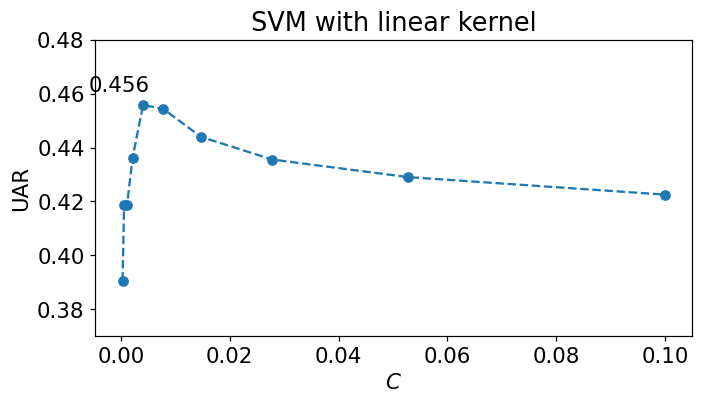

In [13]:
C = np.logspace(-3.5, -1.0, 10, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

# fig,ax=plt.subplots(figsize=(7,3.5))
# plt.rcParams.update({'font.size': 14})
# plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.ylim([0.37, 0.45])
# plt.xlabel('C')
# plt.ylabel('UAR')

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) # 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

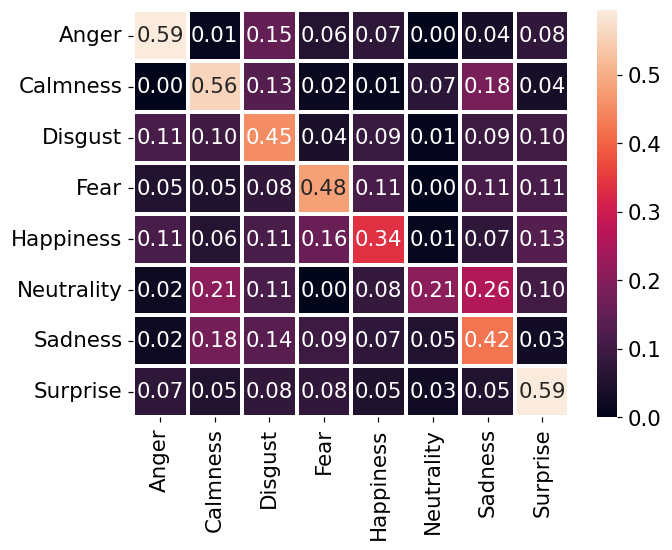

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [14]:
# Confusion matrix
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)

# 5-fold CV (selected feature space)

In [15]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm[:,feature_ind])
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

In [16]:
X_new

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-1.326179,-0.865550,0.350214,0.840500,1.682430,-0.707896,-0.020300,-0.084387,0.172226,1.972389,...,-0.171581,0.320386,0.378692,0.303059,-0.547827,-0.134175,-0.412461,-0.884660,-1.106907,0.987905
1,-0.746059,-0.558509,0.204453,0.019510,0.950253,-1.239457,-0.610736,-0.153646,0.613144,0.647493,...,-0.948772,-0.921689,-0.966724,-0.718038,-0.879547,-0.384878,-0.006407,-0.640903,0.513084,-0.583977
2,0.392777,-0.112181,0.239656,0.352017,1.306853,-1.282685,-0.120409,-0.911184,0.981156,0.152506,...,-0.362374,-0.435690,-0.800947,-0.533889,1.028115,0.685220,-0.618141,-1.261890,-0.740132,2.394697
3,-1.355222,-0.871340,0.599826,-0.213259,-0.384841,-0.308557,0.838620,-1.575944,-0.562788,1.409404,...,0.805032,1.055052,1.074379,0.634002,-0.850787,0.561642,0.141096,-1.013561,-0.529074,-0.637288
4,-1.374829,-0.530920,0.417719,-0.529527,-0.109418,0.313703,1.825148,-0.645613,0.343931,1.757624,...,1.528646,2.380480,1.049962,0.691989,-0.862193,1.999628,-0.439787,-0.883629,-0.077498,-0.144757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-1.118079,-0.962037,0.098770,-1.273444,-0.200904,-1.033634,0.325818,1.494971,0.995423,-0.402387,...,-0.763993,1.708089,1.622761,1.054001,0.196229,0.991508,-0.499437,0.092719,-0.998586,-0.859015
1436,-0.190430,-0.051689,1.207089,-0.611534,-0.334723,-0.048884,1.140966,-0.894729,-0.063867,0.399012,...,2.042430,1.302288,1.612017,0.522795,1.749666,1.087294,0.081307,0.052203,0.400631,-1.440430
1437,-1.930804,-0.309895,-1.095740,-1.395754,0.132618,-0.223597,-0.103797,1.108665,0.205071,-0.567749,...,0.975074,1.237795,1.289363,-0.574101,0.680585,1.178085,0.236277,-0.291877,-0.819892,-1.858146
1438,-1.191132,-0.512036,-0.717332,-0.935597,-0.540781,-2.002356,-0.230809,1.432662,1.012529,0.113842,...,-1.036383,-0.969465,1.473954,0.431326,0.686091,0.512360,-0.615214,0.249460,-0.815675,-0.700458


## GridSearch

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.69it/s]

UAR = 0.281


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.28it/s]

UAR = 0.292


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.53it/s]

UAR = 0.300


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.85it/s]

UAR = 0.309


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.44it/s]

UAR = 0.327


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.70it/s]

UAR = 0.347


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.19it/s]

UAR = 0.365


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.06it/s]

UAR = 0.375


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.61it/s]

UAR = 0.382


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.14it/s]

UAR = 0.383


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.82it/s]

UAR = 0.382


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.98it/s]

UAR = 0.387


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.07it/s]

UAR = 0.387


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.63it/s]

UAR = 0.388


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.83it/s]

UAR = 0.389


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.31it/s]

UAR = 0.396


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.36it/s]

UAR = 0.408


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.42it/s]

UAR = 0.410


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.89it/s]

UAR = 0.411


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.17it/s]

UAR = 0.411


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.49it/s]

UAR = 0.413


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.03it/s]

UAR = 0.419


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.42it/s]

UAR = 0.421


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.29it/s]

UAR = 0.414


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.35it/s]

UAR = 0.417


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.88it/s]

UAR = 0.402


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.43it/s]

UAR = 0.408


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.97it/s]

UAR = 0.410


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.99it/s]

UAR = 0.413


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.84it/s]

UAR = 0.408


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.25it/s]

UAR = 0.406


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.86it/s]

UAR = 0.410


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.93it/s]

UAR = 0.400


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.99it/s]

UAR = 0.393


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.50it/s]

UAR = 0.398


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.81it/s]

UAR = 0.393


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.71it/s]

UAR = 0.395


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  6.81it/s]

UAR = 0.404


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  5.82it/s]

UAR = 0.404


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


UAR = 0.396
UAR_best = 0.421, C_best = 0.030


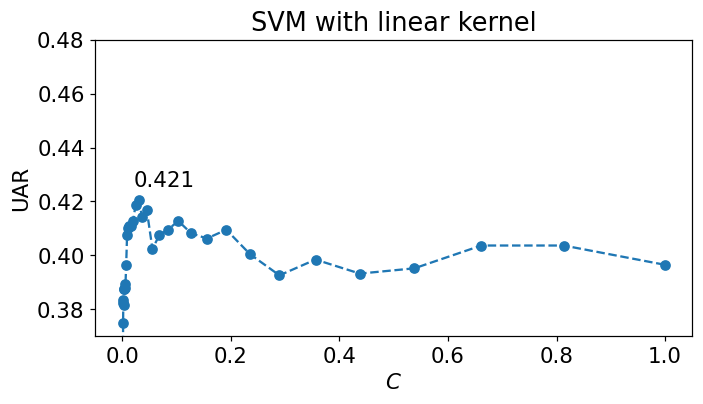

In [17]:
C = np.logspace(-3.5, -0.0, 40, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

## Confusion matrix

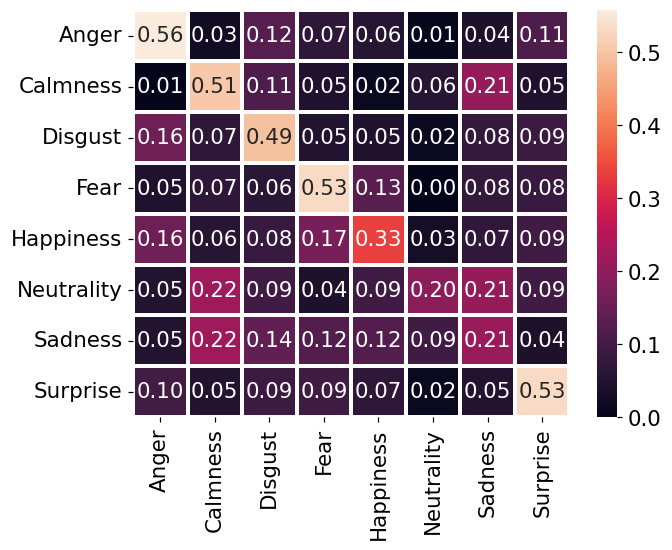

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [18]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)